In [2]:
import tensorflow as tf
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda




In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.python.keras.engine.input_spec import InputSpec
from sklearn import preprocessing
import XAenc as xa
import seaborn as sns

tf.random.set_seed(0)
np.random.seed(0)

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf.executing_eagerly()

ModuleNotFoundError: No module named 'sklearn'

In [4]:
# This gives a nice interpretation of the attention weights
# as well as the new features
PARAMS = {  
            'p' : 0.5,
            'no_redun': 3,
    
            'corr': 0.2,
    
            'train_data': 1000,
            'val_data': 100,
            'test_data': 1000,

            'type_problem': 'classification',
            #'type_problem': 'regression',
    
            'batch_size': 32,
    
            'num_layers': 1,
            'arch_enc': [4],
            'num_heads': 1,
            'dff': 128,
            'arch_contrib': [128, 128],
    
            'no_epochs': 500,
            'rate': 0.1
        }

if PARAMS['type_problem'] == 'classification':
    # if classification we have one output
    PARAMS['arch_contrib'].append(2)
else:
    # if regression we have one output
    PARAMS['arch_contrib'].append(1)

# Generate Data

In [5]:
# classification
def generate_data_model_1(no_samp, p, no_random):
    # AGE and BMI are independent
    
    #age_bmi = np.random.randn(no_samp, 2)
    age_bmi = np.random.multivariate_normal([0,0], 
                                            [[1,PARAMS['corr']],[PARAMS['corr'],1]], 
                                            no_samp)*2*1.58-1.58
    age = age_bmi[:,[0]]*1.58/2
    bmi = age_bmi[:,[1]]*2.58/2
    #age = np.random.random(no_samp).reshape(-1,1)*2*1.58-1.58
    #bmi = np.random.random(no_samp).reshape(-1,1)*2*2.58-2.58
    noise = np.random.random(no_samp).reshape(-1,1)*0.1
    
    redun = np.random.randn(no_samp, no_random)
    
    sigmoid = lambda x: 1/(1 + np.exp(-x))
    
    #y_raw = (1.265*age + 0.0233) + (1-p)*(0.388*bmi-0.325) + p*(1.714*bmi**2-1)
    contrib_0 = 0.0233 + (1-p)*(-0.325) + p*(-1)
    contrib_age = 1.265*age
    contrib_bmi = (1-p)*0.388*bmi + p*1.714*bmi**2
    
    y_raw = contrib_0 + contrib_age + contrib_bmi + noise
    y_prob = np.reshape(sigmoid(y_raw),(-1,1))
    y = np.multiply(y_prob >= 0.5,1)
    
    # need to generate the label with the given probability
    #u = np.random.random(size=y_prob.shape)
    #y = np.multiply(u > y_prob,1)
    
    contributions = np.hstack([np.ones((no_samp,1))*contrib_0, contrib_age.reshape(-1,1), contrib_bmi.reshape(-1,1)])
    
    return np.hstack([y, age, bmi, redun]), contributions

# regression
def generate_data_model_1_regress(no_samp, p, no_random):
    # AGE and BMI are independent
    
    #age_bmi = np.random.randn(no_samp, 2)
#    cofound = np.random.random(no_samp).reshape(-1,1)
#     age = 0.5*(cofound + np.random.random(no_samp).reshape(-1,1))*2*1.58-1.58
#     bmi = 0.2*(cofound + 4*np.random.random(no_samp).reshape(-1,1))*2*1.58-1.58
#     age = np.random.random(no_samp).reshape(-1,1)*2*1.58-1.58
#     bmi = np.random.random(no_samp).reshape(-1,1)*2*2.58-2.58

    age_bmi = np.random.multivariate_normal([0,0], 
                                            [[1,PARAMS['corr']],[PARAMS['corr'],1]], 
                                            no_samp)
    age = age_bmi[:,[0]]*1.58/2
    bmi = age_bmi[:,[1]]*2.58/2

    noise = np.random.random(no_samp).reshape(-1,1)*0.1
    
    redun = np.random.randn(no_samp, no_random)
    
    sigmoid = lambda x: 1/(1 + np.exp(-x))
    
    #y_raw = (1.265*age + 0.0233) + (1-p)*(0.388*bmi-0.325) + p*(1.714*bmi**2-1)
    contrib_0 = 0.0233 + (1-p)*(-0.325) + p*(-1)
    contrib_age = 1.265*age
    contrib_bmi = (1-p)*0.388*bmi + p*1.714*bmi**2
    y_raw = contrib_0 + contrib_age + contrib_bmi + noise
    #y_prob = np.reshape(sigmoid(y_raw),(-1,1))
    #y = np.multiply(y_prob >= 0.5,1)
    
    # need to generate the label with the given probability
    #u = np.random.random(size=y_prob.shape)
    #y = np.multiply(u > y_prob,1)
    
    contributions = np.hstack([np.ones((no_samp,1))*contrib_0, contrib_age.reshape(-1,1), contrib_bmi.reshape(-1,1)])
    
    return np.hstack([y_raw, age, bmi, redun]), contributions

# Data Processing

In [6]:
# Generate the data

train_size = PARAMS['train_data']
test_size = PARAMS['test_data']

if PARAMS['type_problem'] == 'classification':
    train_dataset, train_contributions = generate_data_model_1(PARAMS['train_data'],
                                                               PARAMS['p'],
                                                               PARAMS['no_redun'])
    x_train = train_dataset[:,1:]
    y_train = train_dataset[:,0]
    
    test_dataset, test_contributions = generate_data_model_1(PARAMS['test_data'],
                                                             PARAMS['p'],
                                                             PARAMS['no_redun'])
    x_test = test_dataset[:,1:]
    y_test = test_dataset[:,0]
    
    val_dataset, val_contributions = generate_data_model_1(PARAMS['val_data'],
                                                           PARAMS['p'],
                                                           PARAMS['no_redun'])
    x_val = val_dataset[:,1:]
    y_val = val_dataset[:,0]    
    
    
else:
    train_dataset, train_contributions = generate_data_model_1_regress(PARAMS['train_data'],
                                                                       PARAMS['p'],
                                                                       PARAMS['no_redun'])
    x_train = train_dataset[:,1:]
    y_train = train_dataset[:,0]    
    
    test_dataset, test_contributions = generate_data_model_1_regress(PARAMS['test_data'],
                                                                     PARAMS['p'],
                                                                     PARAMS['no_redun'])
    x_test = test_dataset[:,1:]
    y_test = test_dataset[:,0] 
    
    val_dataset, val_contributions = generate_data_model_1_regress(PARAMS['val_data'],
                                                                   PARAMS['p'],
                                                                   PARAMS['no_redun'])
    x_val = val_dataset[:,1:]
    y_val = val_dataset[:,0]      
    
#scaler = preprocessing.MinMaxScaler(feature_range=(1, 2))
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_val_scaled = scaler.transform(x_val)

# TF Dataset Generator

In [7]:
def kernel(M,S):
    from scipy.special import comb
    
    b = 0.0
    
    if (S == 0) | (S == M):
        #S = 1/2
        #S = M/2
        S = M-1
        return (M-1.0)/(comb(M,S)*S*(M-S)+b)
        #return 0.0
    else:
        return (M-1.0)/(comb(M,S)*S*(M-S)+b)
    
def gen_series():
    i = 0
    while True:
        ind = np.random.randint(x_train_scaled.shape[0])
        tmp = x_train_scaled[ind,:].copy()

        p_miss = np.random.uniform()
        # p_miss = PARAMS['p_miss']
        
        set0 = np.random.choice(2,size=x_train_scaled.shape[1], p=[1-p_miss, p_miss]) == 1
        tmp[set0] = np.nan
        
        M = x_train_scaled.shape[1]
        S = M-np.sum(tf.math.is_nan(tmp))
        
        sample_weight = kernel(M,S)

        yield tmp, y_train[ind], sample_weight
        
# dataset generator
ds_train_scaled = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.float32, tf.float32, tf.float32), 
    output_shapes=((x_train_scaled.shape[1],), (), ()))

ds_train_scaled = ds_train_scaled.batch(PARAMS['batch_size'])

# Model

In [9]:
class MSEPrintingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print('Train performance for epoch {}.'.format(epoch))
            for k, v in logs.items():
                print(' - ', k, ' = ', v)

#lr_schedule = xa.CustomSchedule(PARAMS['d_model'])
#opt = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

#es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='min', min_delta=0.01, verbose=1, patience=200)
#es = tf.keras.callbacks.EarlyStopping(monitor='MSE', mode='min', min_delta=0.01, verbose=1, patience=200)

msecb = MSEPrintingCallback()

# MODEL

my_model = xa.XAModel(PARAMS['num_layers'], PARAMS['arch_enc'], 
                      PARAMS['num_heads'], PARAMS['dff'], 
                      PARAMS['arch_contrib'], PARAMS['type_problem'],
                      PARAMS['rate'])

if PARAMS['type_problem'] == 'classification':
    my_model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy')    
else:
    my_model.compile(optimizer=opt,
                  loss='mean_squared_error')

In [10]:
# my_model.fit(x_train_scaled, y_train, epochs=PARAMS['no_epochs'],
#             callbacks=[msecb], verbose=0)
my_model.fit(ds_train_scaled, epochs=PARAMS['no_epochs'], 
             steps_per_epoch=PARAMS['train_data']//PARAMS['batch_size'], 
             callbacks=[msecb],
             verbose=0)

my_model.summary()

    def get_everything(self, inputs, training):

        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # mask is going to be extracted by finding NaNs
        inputs_nan = tf.math.is_nan(inputs)
        inputs = tf.where(inputs_nan, tf.zeros_like(inputs), inputs)
        #mask = tf.cast(inputs_nan, tf.float32)[:, tf.newaxis, tf.newaxis, :]
        mask = tf.expand_dims(inputs_nan,2) | tf.expand_dims(inputs_nan,1) 
        mask = tf.cast(mask, tf.float32)[:, tf.newaxis, :, :]
        #print('Mask')
        #print(mask)
        #mask = None

        # get final embeddings
        final_embd, attn_weights = self.encoder(inputs, training, mask) # (batch_size, input_seq_len, d_model)
        #final_embd = self.ffn(tmp_embd)

        phi = self.ffn_att(final_embd) # (batch_size, input_seq_len, no_outputs)
        y = tf.math.reduce_sum(phi, axis=1, keepdims=False) # (batch_size, no_outputs)
        y += self.bias # (batch_size, no_outputs)
        
        i

TypeError: You are attempting to use Python control flow in a layer that was not declared to be dynamic. Pass `dynamic=True` to the class constructor.
Encountered error:
"""
in converted code:

    D:\workzone\syncgoogledrive\XAenc.py:491 call  *
        y, y_logits, phi, final_embd, attn_weights = self.get_everything(inputs, training)
    D:\workzone\syncgoogledrive\XAenc.py:465 get_everything
        if training:
    C:\Users\mchowdh5\AppData\Local\Continuum\anaconda3\envs\base_tf200\lib\site-packages\tensorflow_core\python\framework\ops.py:765 __bool__
        self._disallow_bool_casting()
    C:\Users\mchowdh5\AppData\Local\Continuum\anaconda3\envs\base_tf200\lib\site-packages\tensorflow_core\python\framework\ops.py:534 _disallow_bool_casting
        self._disallow_in_graph_mode("using a `tf.Tensor` as a Python `bool`")
    C:\Users\mchowdh5\AppData\Local\Continuum\anaconda3\envs\base_tf200\lib\site-packages\tensorflow_core\python\framework\ops.py:523 _disallow_in_graph_mode
        " this function with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

"""

In [7]:
results = my_model.evaluate(x_train_scaled, y_train, verbose=2)
results

1000/1000 - 1s - loss: 0.0798


0.07983512227237224

In [8]:
results = my_model.evaluate(x_test_scaled, y_test, verbose=2)
results

1000/1000 - 0s - loss: 0.0990


0.09903474128246308

In [9]:
if PARAMS['type_problem'] == 'classification':
    y, y_logits, phi, final_embd, attn_weights = my_model.get_everything(x_test_scaled, training=False)
else:
    y, phi, final_embd, attn_weights = my_model.get_everything(x_test_scaled, training=False)
    
print(y.shape)
print(phi.shape)
print(final_embd.shape)
    
my_shap = tf.squeeze(phi).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1000, 2)
(1000, 5, 2)
(1000, 5, 4)


In [10]:
def get_R2(y_approx):

    return 1-np.std(y_test-y_approx)**2/np.std(y_test)**2

if PARAMS['type_problem'] == 'classification':
    print( 'Accuracy = ', np.sum(np.argmax(y, axis=1) == y_test)/1000)
else:
    y = tf.squeeze(y)
    #bias = np.mean(y - np.sum(phi, axis=1))

    print('R2 all = %2d' % (100*get_R2( y )))
    print('R2 rel = %2d' % (100*get_R2( np.sum(phi[:,:2], axis=1).flatten() )))
    print('R2 irr = %2d' % (100*get_R2( np.sum(phi[:,2:], axis=1).flatten() )))
    print('model bias  = ', my_model.bias.numpy()[0][0])
    print('mean y_test = ', np.mean(y_test))
    plt.scatter(y_test, y)

Accuracy =  0.957


In [11]:
# x_test_tst = x_test_scaled[:2,:].copy()
# x_test_tst[0,0] = np.nan
# x_test_tst[1,2] = np.nan
# print(x_test_tst)

# y_tst, phi_tst, final_embd_tst, attn_weights_tst = my_model.get_everything(x_test_tst, training=False)

# print(y_tst.shape)
# print(phi_tst)
# print(final_embd_tst)

In [12]:
# inputs_nan = tf.math.is_nan(x_test_tst)
# inputs = tf.where(inputs_nan, tf.zeros_like(x_test_tst), x_test_tst)
# #mask = tf.cast(inputs_nan, tf.float32)[:, tf.newaxis, tf.newaxis, :]
# mask = tf.expand_dims(inputs_nan,2) | tf.expand_dims(inputs_nan,1) 
# mask = tf.cast(mask, tf.float32)[:, tf.newaxis, :, :]
# mask

Text(0, 0.5, 'Contribution')

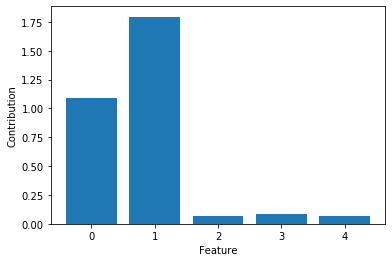

In [13]:
if PARAMS['type_problem'] == 'regression':
    plt.bar(range(my_shap.shape[1]), np.abs(my_shap).mean(axis=0))
else:
    plt.bar(range(my_shap.shape[1]), np.abs(my_shap[:,:,0]).mean(axis=0))
    
plt.xticks(range(my_shap.shape[1]))
plt.xlabel('Feature')
plt.ylabel('Contribution')

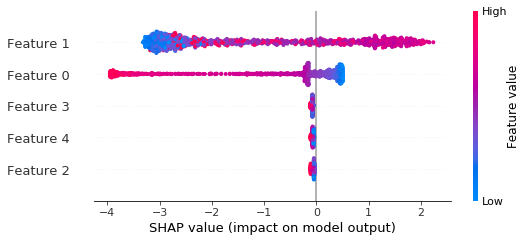

In [14]:
import shap
if PARAMS['type_problem'] == 'regression':
    shap.summary_plot(my_shap, x_test_scaled)
else:    
    shap.summary_plot(my_shap[:,:,0], x_test_scaled)

In [15]:
def get_key(lst, x_test_scaled):
    tmp = '0'*x_test_scaled.shape[1]
    mylist = list(tmp)
    for i in lst:
        mylist[i-1] = '1'
    tmp = ''.join(mylist)
    return tmp

def exact_shap(my_model, x_test_scaled):
    
    from itertools import permutations 
    perm_lists = list(permutations(range(1, x_test_scaled.shape[1]+1))) 
    #print(perm_lists)
    
    all_results = {}
    shap_val = np.zeros(x_test_scaled.shape)

    for l in perm_lists:
        #print(l)

        for i in range(x_test_scaled.shape[1]):
            ind = l.index(i+1)
            lst = l[:ind+1]
            perm_key = get_key(lst, x_test_scaled)        
            if perm_key in all_results.keys():
                result_with = all_results[perm_key]
            else:

                null_lst = l[ind+1:]
                #print('null: ', null_lst)
                x_tst_adj = x_test_scaled.copy()
                sel = np.array(null_lst)-1
                if sel.shape[0] > 0:
                    x_tst_adj[:,sel] = np.nan
                    
                if PARAMS['type_problem'] == 'classification':
                    y, y_logits, phi, final_embd, attn_weights = my_model.get_everything(x_tst_adj, training=False)
                    result_with = y_logits[:,0]
                else:
                    result_with = my_model.predict(x_tst_adj)
                all_results[perm_key] = result_with
                #print(get_key(lst, x_test_scaled))


            lst = l[:ind]
            perm_key = get_key(lst, x_test_scaled)
            if perm_key in all_results.keys():
                result_without = all_results[perm_key]
            else:

                null_lst = l[ind:]
                #print('null: ', null_lst)
                x_tst_adj = x_test_scaled.copy()
                sel = np.array(null_lst)-1
                if sel.shape[0] > 0:
                    x_tst_adj[:,sel] = np.nan
                    
                if PARAMS['type_problem'] == 'classification':
                    y, y_logits, phi, final_embd, attn_weights = my_model.get_everything(x_tst_adj, training=False)
                    result_without = y_logits[:,0]
                else:
                    result_without = my_model.predict(x_tst_adj)
                all_results[perm_key] = result_without
                #print(get_key(lst, x_test_scaled))

            if PARAMS['type_problem'] == 'classification':
                shap_val[:,i] += result_with - result_without
            else:
                shap_val[:,[i]] += result_with - result_without

    shap_val /= len(perm_lists)    
    
    return shap_val

Text(0, 0.5, 'Contribution')

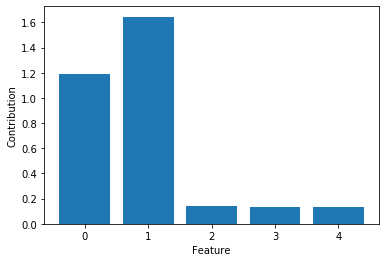

In [16]:
shap_val = exact_shap(my_model, x_test_scaled)

plt.bar(range(shap_val.shape[1]), np.abs(shap_val).mean(axis=0))
plt.xticks(range(shap_val.shape[1]))
plt.xlabel('Feature')
plt.ylabel('Contribution')

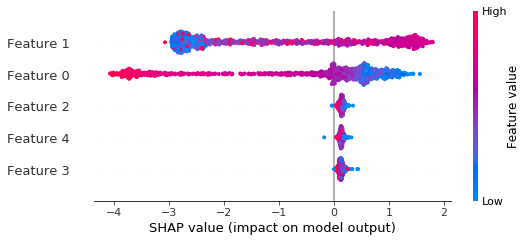

In [17]:
import shap
shap.summary_plot(shap_val, x_test_scaled)

Text(0.5, 1.0, 'bmi - contributions (approx vs exact)')

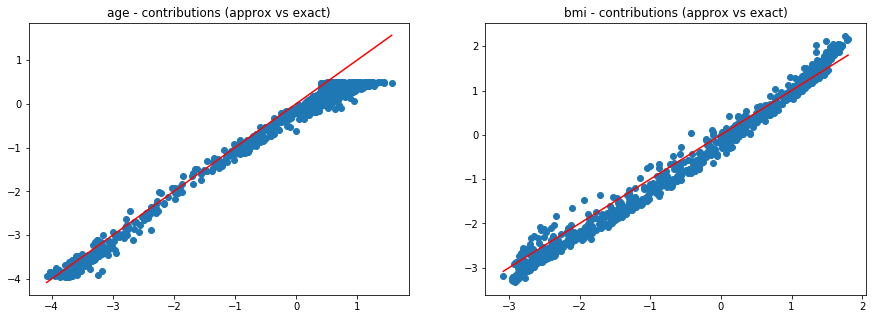

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
if PARAMS['type_problem'] == 'classification':
    plt.scatter(shap_val[:,0], my_shap[:,0,0])
else:
    plt.scatter(shap_val[:,0], my_shap[:,0])
plt.plot((shap_val[:,0].min(),shap_val[:,0].max()), 
         (shap_val[:,0].min(),shap_val[:,0].max()), 'r')
plt.title('age - contributions (approx vs exact)')

plt.subplot(1,2,2)
if PARAMS['type_problem'] == 'classification':
    plt.scatter(shap_val[:,1], my_shap[:,1,0])
else:
    plt.scatter(shap_val[:,1], my_shap[:,1])
plt.plot((shap_val[:,1].min(),shap_val[:,1].max()), 
         (shap_val[:,1].min(),shap_val[:,1].max()), 'r')
plt.title('bmi - contributions (approx vs exact)')

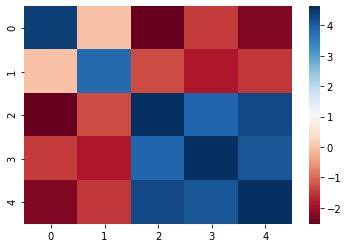

In [19]:
innerProd = tf.matmul( final_embd, tf.transpose(final_embd, perm=(0,2,1)) )
avgAbsInnerProd = tf.reduce_mean(innerProd, axis=0 )
sns.heatmap(avgAbsInnerProd, cmap='RdBu')

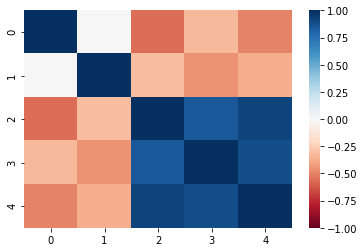

In [20]:
sM = tf.expand_dims( tf.sqrt(tf.reduce_sum(final_embd*final_embd, axis=2)), axis=2)
norm = tf.matmul(sM, tf.transpose(sM, perm=(0,2,1)))
simMat = tf.reduce_mean( innerProd/norm, axis=0 )
sns.heatmap(simMat, cmap='RdBu', vmin=-1, vmax=1)

In [21]:
# M = final_embd[1,:,:]
# sns.heatmap(tf.abs(tf.matmul(M, tf.transpose(M))), cmap='Greys')

In [22]:
# sM = tf.reshape(tf.sqrt(tf.reduce_sum(M*M, axis=1)),[1,-1])
# sns.heatmap(tf.matmul(tf.transpose(sM),sM), cmap='Greys')
# sM.shape

In [23]:
# simM = tf.matmul(M, tf.transpose(M))/tf.matmul(tf.transpose(sM),sM)
# sns.heatmap(simM, cmap='Greys')

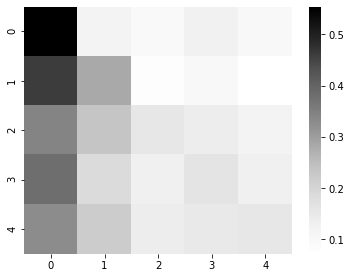

In [24]:
plt.figure(figsize=(6,10))
for i in range(PARAMS['num_layers']):
    plt.subplot(PARAMS['num_layers']+1,1,i+1)
    sns.heatmap(tf.reduce_mean(tf.squeeze(attn_weights[i]),axis=0), cmap='Greys')

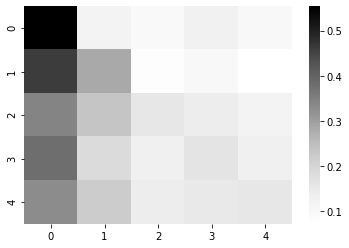

In [25]:
M = tf.reduce_mean(tf.squeeze(attn_weights[0]),axis=0)

for i in range(PARAMS['num_layers']-1):
    M += tf.reduce_mean(tf.squeeze(attn_weights[i+1]),axis=0)
    
sns.heatmap(M, cmap='Greys')

In [26]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.scatter(contributions[train_size:,1], my_shap[:,0])
# plt.plot(range(-2,5), range(-2,5), 'r')
# plt.title('age - contributions (approx vs true)')
# plt.subplot(1,2,2)
# plt.scatter(contributions[train_size:,2], my_shap[:,1])
# plt.plot(range(-2,5), range(-2,5), 'r')
# plt.title('bmi - contributions (approx vs true)')

In [27]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.scatter(contributions[train_size:,1], shap_val[:,0])
# plt.plot(range(-2,5), range(-2,5), 'r')
# plt.title('age - contributions (exact vs true)')
# plt.subplot(1,2,2)
# plt.scatter(contributions[train_size:,2], shap_val[:,1])
# plt.plot(range(-2,5), range(-2,5), 'r')
# plt.title('bmi - contributions (exact vs true)')